In [1]:
using Plots

T = 1.0
dt = 0.0001
t = 0:dt:4T;

# Elastância

## Simaan *et. al*

$$ E(t) = (E_{max} - E_{min})E_n(t_n) + E_{min} $$

onde:

$$
E_n(t) = 1.55 * \left[ \frac{\left(\frac{t_n}{0.7}\right)^{1.9}}{1 + \left(\frac{t_n}{0.7}\right)^{1.9}} \right] * \left[ \frac{1}{1 + \left(\frac{t_n}{1.17}\right)^{21.9}} \right]
$$

In [2]:
Emax = 2.1
Emin = 0.06
HR = 75
tc = 60 / HR
Tmax = 0.2 + 0.15tc

function En(tn)
    tn = (tn % T) / Tmax
    n1 = (tn / 0.7) ^ 1.9
    n2 = (tn / 1.17) ^ 21.9
    return 1.55 * (n1 / (1 + n1)) * (1 / (1 + n2))
end;

function Esimaan(t) 
    return (Emax - Emin) * En(t) + Emin
end;

## Lim *et. al*

$$  
e_v(t) = 
    \begin{cases}
        sin(\frac{\pi(t - t_{sh, i})}{2T_{r,i}})^2 &\quad t_{sh, i} \leq t < (t_{sh,i} + T_{r, i}) \\
        cos(\frac{\pi(t - t_{sh, i} - T_{r, i})}{2(T_{sys,i} - T_{r,i})})^2 &\quad t_{sh, i} (t_{sh,i} + T_{r, i}) \leq t < (t_{sh, i} + T_{sys, i}) \\
        0 &\quad 0 \leq t < (t_{sh,i}) \text{ or } (t_{sh, i} + T_{sys, i}) \leq t < T \\
    \end{cases}
$$

In [3]:
k_sys = 0.1
t_sh = 0

function Elim_n(t, T_sys0 = 0.58, k_r = 0.83)
    T_sys = T_sys0 - (k_sys / T)
    T_r = k_r * T_sys
    t %= T
    if ((t_sh + T_sys) <= t < T) || (0.0 <= t < t_sh)    
        return 0.0
    elseif t_sh <= t < (t_sh + T_r)
        num = π * (t - t_sh)
        den = 2T_r
        return sin(num / den)^2
    elseif (t_sh + T_r) <=  t < (t_sh + T_sys)
        num = π * (t - t_sh - T_r)
        den = 2.0 * (T_sys - T_r)
        return cos(num / den)^2
    end
end

function Elim(t)
    return (Emax - Emin) * Elim_n(t) + Emin
end;

In [4]:
lim = map(Elim, t)
simaan = map(Esimaan, t);

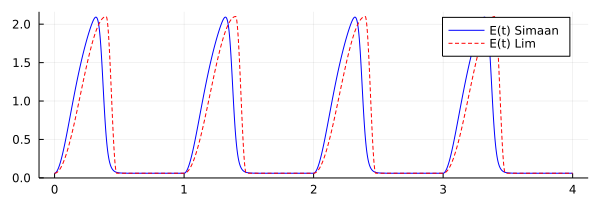

In [5]:
plot(t, simaan, label = "E(t) Simaan", color="blue")
plot!(t, lim, line = :dash, label = "E(t) Lim", size = (600, 200), color="red")

# Modelagem do ventrículo esquerdo

## Constantes

In [6]:
Rs = 1.0000
Rm = 0.0050
Ra = 0.0010
Rc = 0.0398

Cr = 4.4000
Cs = 1.3300
Ca = 0.0800

Ls = 0.0005;

V0 = 10

10

In [7]:
N = length(t)
x = zeros(N, 6)
x1, x2, x3, x4, x5, x6 = eachcol(x)

x[1, :] = [0.0, 10.0, 90.0, 77.0, 0.0, 140.0];

Utilizando as Leis de Kirchoff no circuito obtemos as E.D.Os:

$$
\dot{x_2} = \frac{1}{R_sC_r}(x_3-x_2)-\frac{D_m}{C_rR_m}(x_2-x_1)\\
\dot{x_3} = \frac{1}{R_sC_s}(x_2-x_3)-\frac{1}{C_s}(x_5)\\
\dot{x_4} = \frac{-1}{C_a}x_5+\frac{D_a}{C_aR_a}(x_1-x_4)\\
\dot{x_5} = \frac{1}{L_s}(-x_3+x_4-Rc x_5)\\
\dot{x_6} = \frac{D_a}{R_a}x_4- \left[ \frac{D_m}{R_m}+\frac{D_a}{R_a}\right] Ex_6+\frac{D_m}{R_m}x_2 + \left[ \frac{D_m}{R_m}+\frac{D_a}{R_a} \right]EV_0
$$
onde $x_2$ é pressão no átrio esquerdo ($P_{ae}$), $x_3$ a pressão arterial sistêmica ($P_{as}$), $x_4$ a pressão aórtica ($P_{ao}$), $x_5$ o fluxo aórtico ($Q$), $x_6$ o volume no ventrículo esquerdo ($V_{ve}$) e $x_1$ a pressão no ventrículo esquerdo, dada pela relação
$$
x_1(t)=E(t)(x_6(t)-V_0)
$$

In [8]:
RsCr = 1.0 / (Rs * Cr); RsCs = 1.0 / (Rs * Cs); CrRm = 1.0 / (Cr * Rm); CaRa = 1.0 / (Ca * Ra)
 
E = Esimaan

for i = 1:N-1
    ti = t[i]
    Da = (x1[i] > x4[i]) ? 1 : 0
    Dm = (x2[i] > x1[i]) ? 1 : 0
    drma = Dm / Rm + Da / Ra

    x1[i+1] = E(ti)*(x6[i] - V0)
    x2[i+1] = x2[i] + dt*(RsCr*(x3[i] - x2[i]) - CrRm*Dm*(x2[i] - x1[i]))
    x3[i+1] = x3[i] + dt*(RsCs*(x2[i] - x3[i]) + (1.0/Cs)*x5[i])
    x4[i+1] = x4[i] + dt*((-1.0/Ca)*x5[i] + CaRa*Da*(x1[i] - x4[i]))
    x5[i+1] = x5[i] + dt*((1.0/Ls)*(-x3[i] + x4[i] - Rc*x5[i]))
    x6[i+1] = x6[i] + dt*(((Da/Ra)*x4[i]) - drma*E(ti)*x6[i] + ((Dm/Rm)*x2[i]) + drma*E(ti) * V0)
end

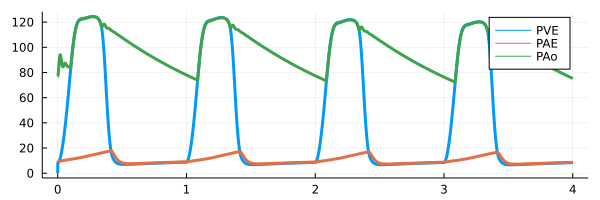

In [9]:
plot(t, [x1, x2, x4], label=["PVE" "PAE" "PAo"], lw=3, size=(600, 200))

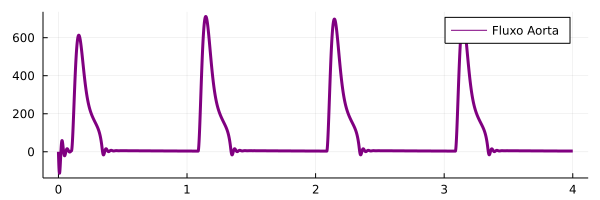

In [10]:
plot(t, x5, label="Fluxo Aorta", color="purple", lw=3, size=(600, 200))

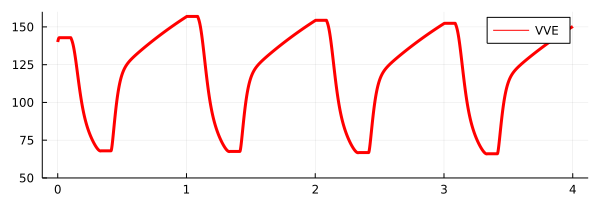

In [11]:
plot(t, x6, label="VVE", color="red", lw=3, size=(600, 200), ylims = (50, 160))

# Referências

[1] Lim E, Dokos S, Cloherty SL, Salamonsen RF, Mason DG, Reizes JA, Lovell NH.**Parameter-optimized model of cardiovascular–rotary blood pump interactions**. IEEE Transactions on Biomedical Engineering. 2009 Sep 18;57(2):254-66.

[2] Simaan MA, Ferreira A, Chen S, Antaki JF, Galati DG. **A dynamical state space representation and performance analysis of a feedback-controlled rotary left ventricular assist device**. IEEE Transactions on Control Systems Technology. 2008 Dec 22;17(1):15-28.